### Setups and Imports

In [14]:
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

In [71]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup


# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to C:\Users\Shashank
[nltk_data]     Prakash\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Shashank
[nltk_data]     Prakash\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Shashank
[nltk_data]     Prakash\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Shashank
[nltk_data]     Prakash\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### Data Wrangling

In [85]:
reviews_all = pd.read_csv("./data/fake reviews dataset.csv")
reviews_all.shape

(40432, 4)

In [86]:
reviews_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40432 non-null  object 
 1   rating    40432 non-null  float64
 2   label     40432 non-null  object 
 3   text_     40432 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.2+ MB


In [4]:
reviews_all.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [12]:
reviews_all['text_length'] = reviews_all['text_'].apply(len)
reviews_all.head(2)

,category,rating,label,text_,text_length
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor...",75
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I...",80


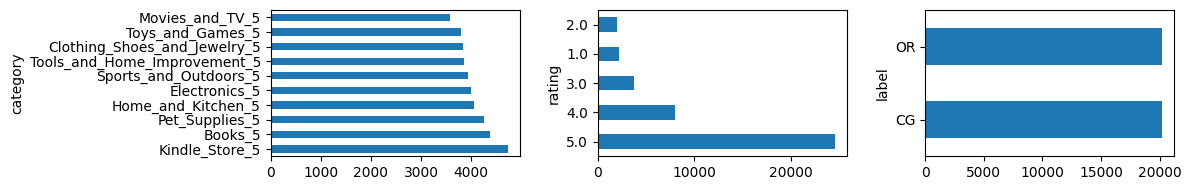

In [30]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(12,2)

reviews_all['category'].value_counts().plot(kind='barh', ax=axes[0])
reviews_all['rating'].value_counts().plot(kind='barh', ax=axes[1])
reviews_all['label'].value_counts().plot(kind='barh', ax=axes[2])
plt.tight_layout()

Text(0.5, 0, 'Review Length (characters)')

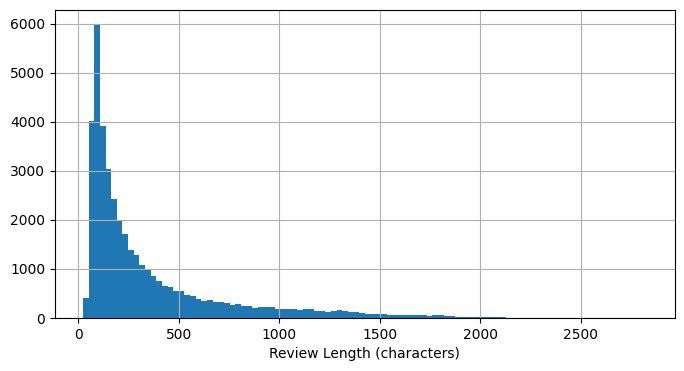

In [81]:
reviews_all['text_length'].hist(bins=100, figsize=(8,4))
plt.xlabel("Review Length (characters)")

<Axes: ylabel='category'>

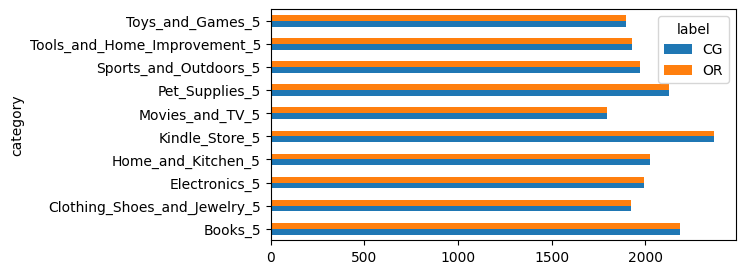

In [56]:
val_counts = reviews_all[['label', 'category']].value_counts().reset_index(name='count')
pivot_df = val_counts.pivot(index='category', columns='label', values='count')
pivot_df.plot(kind='barh', stacked=False, figsize=(6,3))

<Axes: ylabel='rating'>

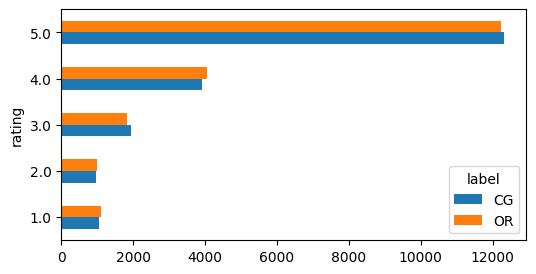

In [57]:
val_counts = reviews_all[['label', 'rating']].value_counts().reset_index(name='count')
pivot_df = val_counts.pivot(index='rating', columns='label', values='count')
pivot_df.plot(kind='barh', stacked=False, figsize=(6,3))

### Text Cleaning | Preprocessing

In [38]:
reviews_all.describe()

,rating,text_length
count,40432.000000,40432.000000
mean,4.256579,351.271963
std,1.144354,369.813570
min,1.000000,24.000000
25%,4.000000,107.000000
50%,5.000000,198.000000
75%,5.000000,439.000000
max,5.000000,2827.000000


In [37]:
reviews_all[reviews_all.text_length>250].head()

,category,rating,label,text_,text_length
1520,Home_and_Kitchen_5,5.0,OR,"<a data-hook=""product-link-linked"" class=""a-li...",347
2223,Home_and_Kitchen_5,5.0,OR,"Once you get used to the settings, it makes de...",254
2290,Home_and_Kitchen_5,1.0,OR,This thermostat worked great at first but soon...,261
2333,Home_and_Kitchen_5,5.0,OR,This is a solid piece of gear. I ordered it af...,253
2353,Home_and_Kitchen_5,5.0,OR,I love my Vellux Blanket and have had them in ...,253


In [61]:
print(reviews_all.loc[1520]['text_'])

<a data-hook="product-link-linked" class="a-link-normal" href="/ORBLUE-Flatware-Pie-Server-Stainless-Steel-Cake-Cutter/dp/B011J5MKPC/ref=cm_cr_arp_d_rvw_txt?ie=UTF8">ORBLUE Flatware Pie Server Stainless Steel Cake Cutter</a>&nbsp;FOR REVIEW

GREAT QUALITY. nice finish good and solid item feels and looks very professional. well worth the purchase


In [62]:
print(reviews_all.loc[2223]['text_'])

Once you get used to the settings, it makes deliciously, moist meats!!
We seared our meat for just a couple minutes after cooking. It is a great kitchen addition and would highly recommend!
We put the seasoned meats in one sealed bag, veggies in another.


In [72]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_review(text):

    # Remove HTML tags using BeautifulSoup
    text = BeautifulSoup(text, "html.parser").get_text()

    # Convert text to lowercase
    text = text.lower()

    # Remove special characters, numbers, and punctuation using regular expressions
    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenize the text
    words = nltk.word_tokenize(text)

    # Remove stopwords and perform lemmatization
    cleaned_text = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    # Join the words back into a single string
    return ' '.join(cleaned_text)

In [76]:
sample_review = reviews_all.loc[1520]['text_']
cleaned_review = clean_review(sample_review)

print("Original Review text : ", sample_review)
print("\n\nCleaned Review : ", cleaned_review)

Original Review text :  <a data-hook="product-link-linked" class="a-link-normal" href="/ORBLUE-Flatware-Pie-Server-Stainless-Steel-Cake-Cutter/dp/B011J5MKPC/ref=cm_cr_arp_d_rvw_txt?ie=UTF8">ORBLUE Flatware Pie Server Stainless Steel Cake Cutter</a>&nbsp;FOR REVIEW

GREAT QUALITY. nice finish good and solid item feels and looks very professional. well worth the purchase


Cleaned Review :  orblue flatware pie server stainless steel cake cutter review great quality nice finish good solid item feel look professional well worth purchase


In [77]:
sample_review = reviews_all.loc[2223]['text_']
cleaned_review = clean_review(sample_review)

print("Original Review text : ", sample_review)
print("\n\nCleaned Review : ", cleaned_review)

Original Review text :  Once you get used to the settings, it makes deliciously, moist meats!!
We seared our meat for just a couple minutes after cooking. It is a great kitchen addition and would highly recommend!
We put the seasoned meats in one sealed bag, veggies in another.


Cleaned Review :  get used setting make deliciously moist meat seared meat couple minute cooking great kitchen addition would highly recommend put seasoned meat one sealed bag veggie another


In [78]:
reviews_all['cleaned_text'] = reviews_all['text_'].apply(clean_review)
reviews_all['cleantext_length'] = reviews_all['cleaned_text'].apply(len)

C:\Users\Shashank Prakash\AppData\Local\Temp\ipykernel_16964\1524789737.py:8: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


Text(0.5, 0, 'Cleaned Review Length (characters)')

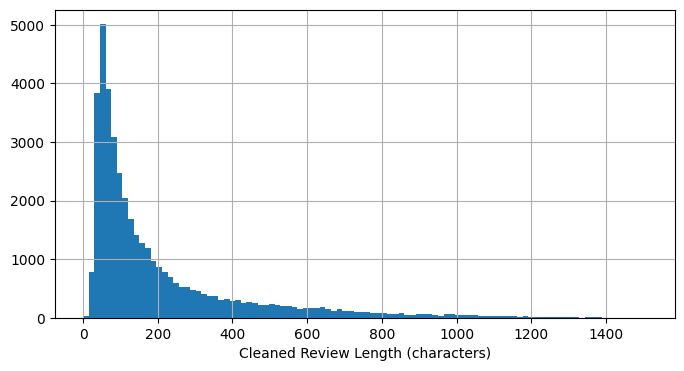

In [82]:
reviews_all['cleantext_length'].hist(bins=100, figsize=(8,4))
plt.xlabel("Cleaned Review Length (characters)")

In [83]:
reviews_all.describe()

,rating,text_length,cleantext_length
count,40432.000000,40432.000000,40432.000000
mean,4.256579,351.271963,202.398298
std,1.144354,369.813570,218.073612
min,1.000000,24.000000,0.000000
25%,4.000000,107.000000,62.000000
50%,5.000000,198.000000,113.000000
75%,5.000000,439.000000,249.000000
max,5.000000,2827.000000,1509.000000


In [84]:
reviews_all.to_pickle("./data/processed_reviews_v1.pkl")